In [8]:
!pip3 install pyspark
!pip3 install findspark

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import findspark
findspark.init()

In [2]:

import pyspark

spark = (
    pyspark.sql.SparkSession.builder
        .appName('MK')
        .master("local[2]") # limit executor to 2 cores
        .config("spark.executor.memory", "8g")
        .config("spark.driver.memory", "8g")
        .config("spark.ui.port", '4040')
        .getOrCreate()
)
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [4]:
from pyspark.sql.types import StructField, IntegerType, StructType, StringType, FloatType
newDF=[StructField('tranaction_id',StringType(),True),
       StructField('tx_datetime',StringType(),True),
       StructField('customer_id',StringType(),True),
       StructField('terminal_id',StringType(),True),
       StructField('tx_amount',FloatType(),True),
       StructField('tx_time_seconds',IntegerType(),True),
       StructField('tx_time_days',IntegerType(),True),
       StructField('tx_fraud',IntegerType(),True),
       StructField('tx_fraud_scenario',IntegerType(),True)
       ]
finalStruct=StructType(fields=newDF)
df = spark.read.csv('s3a://mlops-course-bucket/second_hw/2019-09-21.txt',schema=finalStruct, header=True)

df.show(5)

print(df.printSchema())
print(df.dtypes)

+-------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|tranaction_id|        tx_datetime|customer_id|terminal_id|tx_amount|tx_time_seconds|tx_time_days|tx_fraud|tx_fraud_scenario|
+-------------+-------------------+-----------+-----------+---------+---------------+------------+--------+-----------------+
|     46988237|2019-09-21 09:45:59|          1|        178|    83.11|        2627159|          30|       0|                0|
|     46988238|2019-09-21 19:33:01|          2|        660|    22.15|        2662381|          30|       0|                0|
|     46988239|2019-09-21 18:06:19|          3|        732|    36.83|        2657179|          30|       0|                0|
|     46988240|2019-09-21 16:56:01|         10|        663|     19.3|        2652961|          30|       0|                0|
|     46988241|2019-09-21 05:34:26|         10|        145|   106.51|        2612066|          30|       0|           

# identificators

 
### [x] tranaction_id - проверка символов на цифры. если нулл - удалить. битые - заменить;
### [x] customer_id - проверка символов на цифры. если нулл - удалить. битые - заменить;
### [x] terminal_id - проверка символов на цифры. если нулл - удалить. битые - заменить.


In [8]:
from pyspark.ml import Pipeline, Transformer
from pyspark.sql.functions import col,lit


class ValidationIds(Transformer):
    def __init__(self):
        super(ValidationIds, self).__init__()
        self.counter = {'tranaction_id': 1, 'customer_id': 1, 'terminal_id': 1}

    def _transform(self, df):
        df = df.dropna(subset=list(self.counter.keys())) # drop nans
        
        for colid in self.counter.keys(): # edit non-digits
            dq = df.filter(df[colid].rlike('\D+'))
            df = df[~df[colid].rlike('\D+')]
            dq = dq.withColumn(colid, lit('undefinded_' + colid.split('id')[0] + str(self.counter[colid])))
            self.counter[colid] += 1
            df = df.union(dq)
            
        return df
    


In [24]:
print(df.count())

v = ValidationIds()
df1 = v._transform(df)

print(df1.count())

46994586
46994586


In [25]:
df1.filter(df1['customer_id'].rlike('\D+'))

tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario
47009347,2019-09-21 19:52:15,undefinded_custom...,779,107.75,2663535,30,0,0
47079004,2019-09-21 09:35:34,undefinded_custom...,972,11.88,2626534,30,0,0
47105774,2019-09-21 10:29:57,undefinded_custom...,403,7.6,2629797,30,0,0
47158695,2019-09-21 13:56:17,undefinded_custom...,710,5.57,2642177,30,0,0
47392780,2019-09-21 07:49:27,undefinded_custom...,481,74.61,2620167,30,0,0
47440508,2019-09-21 13:53:24,undefinded_custom...,754,63.82,2642004,30,0,0
47503116,2019-09-21 19:08:16,undefinded_custom...,114,54.13,2660896,30,0,0
47549817,2019-09-21 16:43:46,undefinded_custom...,132,26.74,2652226,30,0,0
47668930,2019-09-21 10:27:52,undefinded_custom...,831,24.74,2629672,30,0,0
47673768,2019-09-21 11:38:18,undefinded_custom...,580,63.21,2633898,30,0,0


# Numeric

### [x] tx_amount, tx_time_seconds, tx_time_days - проверка на >0. если нулл - дать средний. выбросы удалить

In [68]:
df[['tx_amount']].describe()

summary,tx_amount
count,46994586
mean,54.23517020105954
stddev,41.309001673205096
min,0.0
max,4303.07


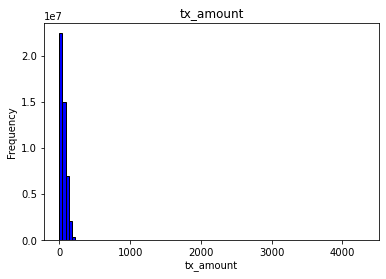

In [97]:
import matplotlib.pyplot as plt
age_values = df.select("tx_amount").rdd.flatMap(lambda x: x).collect()

# Create a frequency plot using matplotlib
plt.hist(age_values, bins=100, color='blue', edgecolor='black')
plt.xlabel("tx_amount")
plt.ylabel("Frequency")
plt.title("origin amount")

# Show the plot
plt.show()

In [43]:
from pyspark.ml.feature import Imputer

amount_imputer = Imputer(inputCol="tx_amount", outputCol="tx_amount", strategy="mean")
amount_imputer_model = amount_imputer.fit(df)

time_seconds_imputer = Imputer(inputCol="tx_time_seconds", outputCol="tx_time_seconds", strategy="mean")
time_seconds_imputer_model = time_seconds_imputer.fit(df)

time_days_imputer = Imputer(inputCol="tx_time_days", outputCol="tx_time_days", strategy="mean")
time_days_imputer_model = time_days_imputer.fit(df)

prep_df = amount_imputer_model.transform(df)
prep_df = time_seconds_imputer_model.transform(prep_df)
prep_df = time_days_imputer_model.transform(prep_df)
prep_df


In [26]:


class ValidationNumerics(Transformer):
    def __init__(self, num_list):
        super(ValidationNumerics, self).__init__()
        self.num_list = num_list
        
    def _transform(self, df):
        for cols in self.num_list:
            df = df[df[cols] > 0] # time has to be > 0
            lower_quan, upper_quan = df.approxQuantile(cols, [0.25, 0.75], 0.05)
            iqr = upper_quan - lower_quan
            lower_extreme = lower_quan - 1.5*iqr
            upper_extreme = upper_quan + 1.5*iqr
            dfu = df.where(df[cols] < upper_extreme)
            df = dfu.where(dfu[cols] > lower_extreme) # delete outliers

        return df

In [27]:
print(df.count())

vn = ValidationNumerics(['tx_amount', 'tx_time_seconds', 'tx_time_days'])
df1 = vn._transform(df)

print(df1.count())

46994586
45709329


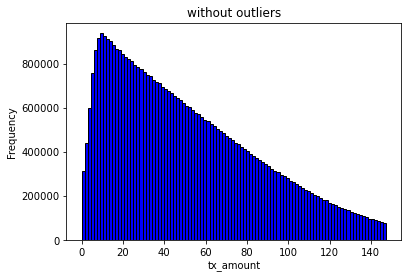

In [28]:
import matplotlib.pyplot as plt
age_values = df1.select("tx_amount").rdd.flatMap(lambda x: x).collect()

# Create a frequency plot using matplotlib
plt.hist(age_values, bins=100, color='blue', edgecolor='black')
plt.xlabel("tx_amount")
plt.ylabel("Frequency")
plt.title("amount without outliers")

# Show the plot
plt.show()

# categotical

### [x] tx_fraud - проверка на а) инт; б) принадледность к 0 или 1. если нулл - дать то, чего больше: 0 или 1.

### [x] tx_fraud_scenario - ohe. если нулл - дать превалирующий. проверка на интервал(?)

In [11]:
df[['tx_fraud']].describe()

summary,tx_fraud
count,46988418
mean,0.05377931642644364
stddev,0.22558169835808653
min,0
max,1


In [13]:
df[['tx_fraud_scenario']].describe()

summary,tx_fraud_scenario
count,46988418
mean,0.10841507794537794
stddev,0.4568780500029875
min,0
max,3


In [34]:
class ValidationBinary(Transformer):
    def __init__(self, bin_list):
        super(ValidationBinary, self).__init__()
        self.bin_list = bin_list
        
    def _transform(self, df):
        for colb in self.bin_list:
            df_not_0 = df[df[colb] != 0]
            df_only_0 = df[df[colb] == 0]
            df_only_1 = df[df[colb] == 1]
            df_not_10 = df_not_0[df_not_0[colb] != 1] # df10 contains not 0 and not 1
            if df_only_0.count() > df_only_1.count():
                df_not_10 = df_not_10.withColumn(colb, lit(0))
            else:
                df_not_10 = df_not_10.withColumn(colb, lit(1))
                
            df = df_only_0.union(df_only_1)
            df = df.union(df_not_10)
        return df

In [35]:
print(df.count())

v = ValidationBinary(['tx_fraud'])
df1 = v._transform(df)

print(df1.count())

46994586
46994586


In [40]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

fraud_scenario_indexer = StringIndexer(inputCol="tx_fraud_scenario", outputCol="tx_fraud_scenario_index")
fraud_scenario_indexer_model = fraud_scenario_indexer.fit(df)
df_prep = fraud_scenario_indexer_model.transform(df)

fraud_scenario_encoder = OneHotEncoder(inputCol="tx_fraud_scenario_index", outputCol="tx_fraud_scenario_encoded")
fraud_scenario_encoder_model = fraud_scenario_encoder.fit(df_prep)
df_prep = fraud_scenario_encoder_model.transform(df_prep)

In [41]:
df_prep

tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,tx_fraud_scenario_index,tx_fraud_scenario_encoded
46988237,2019-09-21 09:45:59,1,178,83.11,2627159,30,0,0,0.0,"(3,[0],[1.0])"
46988238,2019-09-21 19:33:01,2,660,22.15,2662381,30,0,0,0.0,"(3,[0],[1.0])"
46988239,2019-09-21 18:06:19,3,732,36.83,2657179,30,0,0,0.0,"(3,[0],[1.0])"
46988240,2019-09-21 16:56:01,10,663,19.3,2652961,30,0,0,0.0,"(3,[0],[1.0])"
46988241,2019-09-21 05:34:26,10,145,106.51,2612066,30,0,0,0.0,"(3,[0],[1.0])"
46988242,2019-09-21 12:12:51,11,337,53.97,2635971,30,0,0,0.0,"(3,[0],[1.0])"
46988243,2019-09-21 11:05:32,11,973,29.3,2631932,30,0,0,0.0,"(3,[0],[1.0])"
46988244,2019-09-21 15:13:40,11,975,28.59,2646820,30,0,0,0.0,"(3,[0],[1.0])"
46988245,2019-09-21 16:47:20,12,522,88.02,2652440,30,0,0,0.0,"(3,[0],[1.0])"
46988246,2019-09-21 07:57:03,12,522,77.39,2620623,30,0,0,0.0,"(3,[0],[1.0])"


In [44]:
vids = ValidationIds()
vnum = ValidationNumerics(['tx_amount', 'tx_time_seconds', 'tx_time_days'])
amount_imputer = Imputer(inputCol="tx_amount", outputCol="tx_amount", strategy="mean")
time_seconds_imputer = Imputer(inputCol="tx_time_seconds", outputCol="tx_time_seconds", strategy="mean")
time_days_imputer = Imputer(inputCol="tx_time_days", outputCol="tx_time_days", strategy="mean")
vbin = ValidationBinary(['tx_fraud'])
fraud_scenario_indexer = StringIndexer(inputCol="tx_fraud_scenario", outputCol="tx_fraud_scenario_index")
fraud_scenario_encoder = OneHotEncoder(inputCol="tx_fraud_scenario_index", outputCol="tx_fraud_scenario_encoded")

feat_ext_pipe = Pipeline(stages=[
    vids,
    vnum,
    amount_imputer,
    time_seconds_imputer,
    time_days_imputer,
    vbin,
    fraud_scenario_indexer,
    fraud_scenario_encoder
    ]).fit(df)



feat_df = feat_ext_pipe.transform(df)
feat_df

tranaction_id,tx_datetime,customer_id,terminal_id,tx_amount,tx_time_seconds,tx_time_days,tx_fraud,tx_fraud_scenario,tx_fraud_scenario_index,tx_fraud_scenario_encoded
46988237,2019-09-21 09:45:59,1,178,83.11,2627159,30,0,0,0.0,"(2,[0],[1.0])"
46988238,2019-09-21 19:33:01,2,660,22.15,2662381,30,0,0,0.0,"(2,[0],[1.0])"
46988239,2019-09-21 18:06:19,3,732,36.83,2657179,30,0,0,0.0,"(2,[0],[1.0])"
46988240,2019-09-21 16:56:01,10,663,19.3,2652961,30,0,0,0.0,"(2,[0],[1.0])"
46988241,2019-09-21 05:34:26,10,145,106.51,2612066,30,0,0,0.0,"(2,[0],[1.0])"
46988242,2019-09-21 12:12:51,11,337,53.97,2635971,30,0,0,0.0,"(2,[0],[1.0])"
46988243,2019-09-21 11:05:32,11,973,29.3,2631932,30,0,0,0.0,"(2,[0],[1.0])"
46988244,2019-09-21 15:13:40,11,975,28.59,2646820,30,0,0,0.0,"(2,[0],[1.0])"
46988245,2019-09-21 16:47:20,12,522,88.02,2652440,30,0,0,0.0,"(2,[0],[1.0])"
46988246,2019-09-21 07:57:03,12,522,77.39,2620623,30,0,0,0.0,"(2,[0],[1.0])"


# save

In [45]:
feat_df.write.mode("overwrite").parquet("s3a://mlops-course-bucket/third_hw/train.parquet")

# черновик